In [1]:
# -------------------------------------------------------------------
# Shor’s Algorithm (Period Finding) – Clean vs Malicious Dataset
# -------------------------------------------------------------------

# This notebook implements a simplified version of Shor’s Algorithm,
# focusing on the quantum subroutine used for period finding in
# modular exponentiation, which underpins integer factorization.

# Objective:
# - Generate 10 clean Shor-like circuits based on modular periodicity logic
# - Generate 10 malicious circuits with tampered gates, structure, or swaps
# - Extract features from both for anomaly or Trojan detection in quantum circuits

# Dataset Composition:
# - Clean circuits labeled as 0
# - Malicious circuits labeled as 1
# - Each sample includes both structural and behavioral features

# Malicious Strategies:
# - Altered entanglement in modular exponentiation circuit
# - Removal or injection of CNOT, Swap, or CU1 gates
# - Trojan logic inserted post-inverse QFT

# Output:
# - Circuit diagrams and histograms
# - Feature CSVs
# - Combined dataset with visual analytics (class balance, heatmap)

# Tools & Framework:
# - Qiskit + IBM Runtime backends
# - Visualization via matplotlib + seaborn
# - Structural + statistical feature extraction

# Author: Zeeshan Ajmal


In [2]:
# --------------------------------------------------
# Qiskit + Runtime + Visualization + Utilities Setup
# --------------------------------------------------

# Qiskit core
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as norm_sampler

# Visualization
%matplotlib inline
from qiskit.visualization import plot_histogram, plot_circuit_layout
import matplotlib.pyplot as plt
import seaborn as sns

# Data handling
import numpy as np
import pandas as pd
from scipy.stats import entropy as shannon_entropy
import os

# Qiskit Runtime initialization
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='ff1dde434d0dcec5608d0b0166f3df690e5b8258114b55d50805fe2c5c25d03a520f7551cd363d5295b421ab19908870fc00cdfb57a074f0a7eaa6c9ff2fa9e6'
)

# Select backend
backend = service.backend("ibm_brisbane")


In [3]:
# --------------------------------------------------
# Function: Generate Clean Shor-like Circuit (Period Finding)
# --------------------------------------------------

def generate_shor_clean_variation(index):
    """
    Generate a clean version of Shor's algorithm subcircuit
    focused on the quantum period-finding subroutine.

    We simulate a modular exponentiation unitary U^x mod N
    with varying controlled rotations and entanglement.
    """
    n = 3  # input qubits
    qc = QuantumCircuit(n + 1)  # +1 ancillary (work) qubit

    # Step 1: Apply Hadamard to input register (qubits 0-2)
    qc.h(range(n))

    # Step 2: Controlled modular exponentiation (simulated pattern)
    qc.cx(0, 3)
    qc.cx(1, 3)
    qc.ccx(0, 1, 2)  # Simulate controlled modular arithmetic

    # Variation by index: add CP or CU1 with different angles
    angle = (index + 1) * np.pi / 8
    qc.cp(angle, 2, 3)

    # Step 3: Inverse QFT on input qubits
    qc.swap(0, 2)
    qc.h(0)
    qc.cp(-np.pi/2, 1, 0)
    qc.h(1)
    qc.h(2)

    # Step 4: Measure all qubits
    qc.measure_all()

    return qc


In [4]:
# --------------------------------------------------
# Generate & Store Clean Shor Circuit Variants
# --------------------------------------------------

# Dictionary to hold clean Shor circuits
shor_clean_circuits = {}

# Generate 10 clean variations
for i in range(10):
    circuit = generate_shor_clean_variation(i)
    shor_clean_circuits[f"shor_clean_{i}"] = circuit


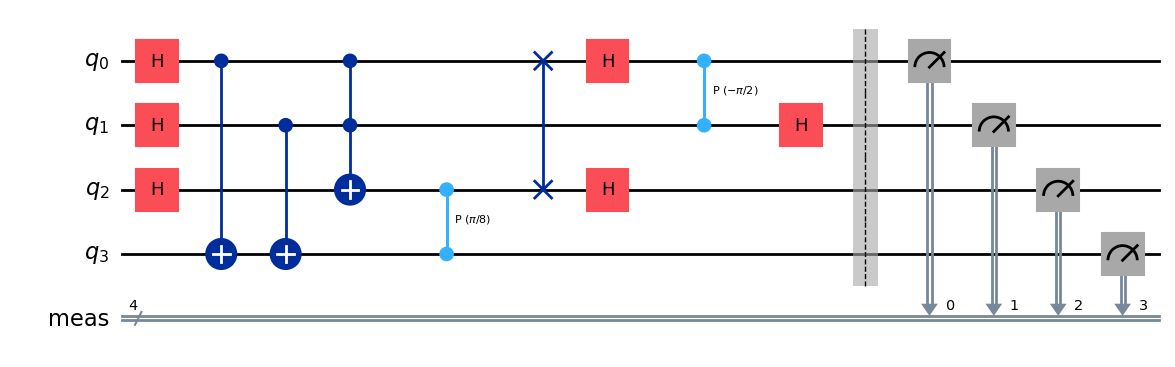

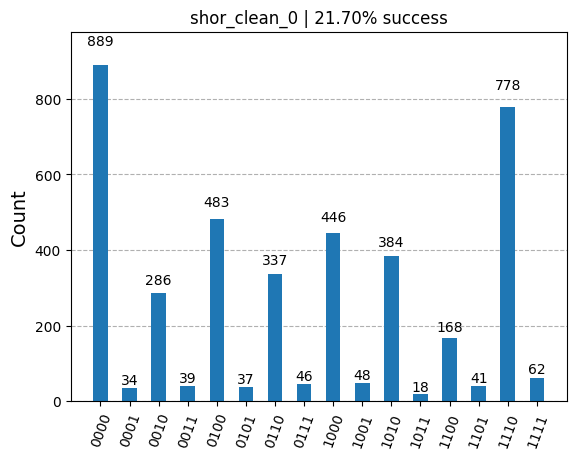

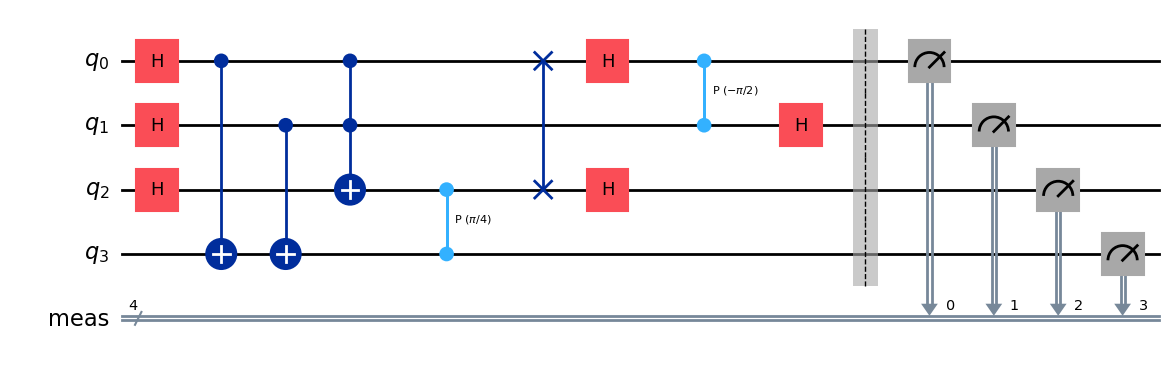

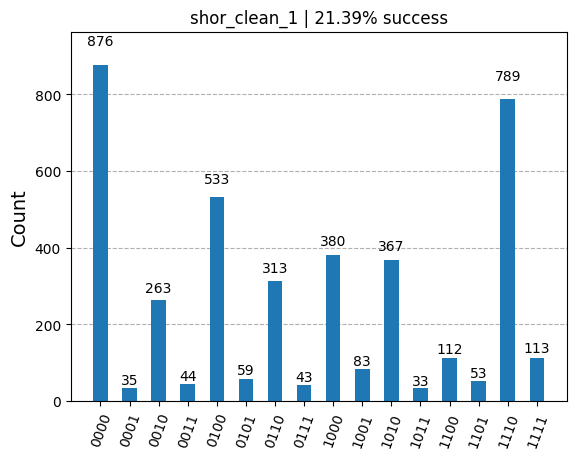

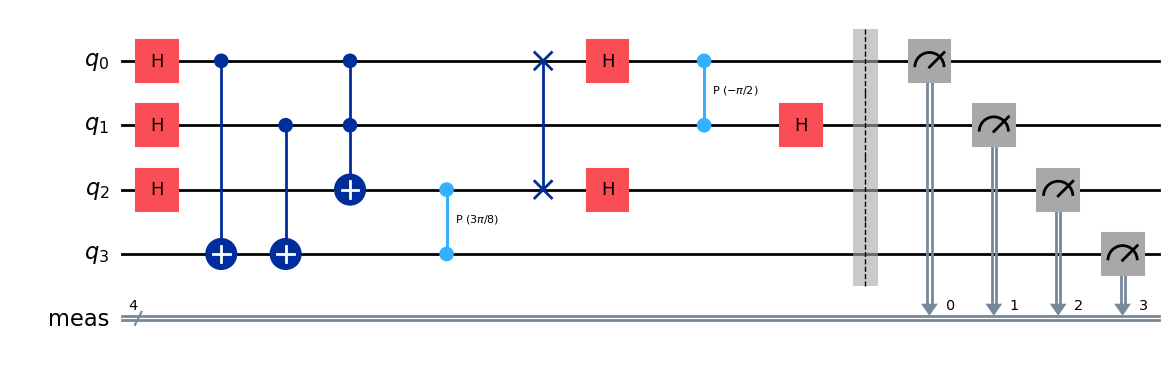

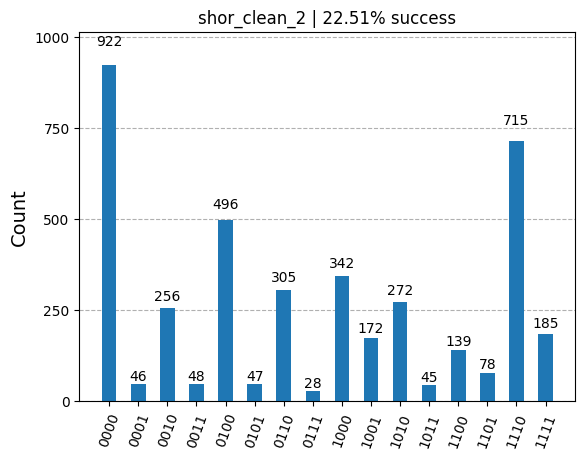

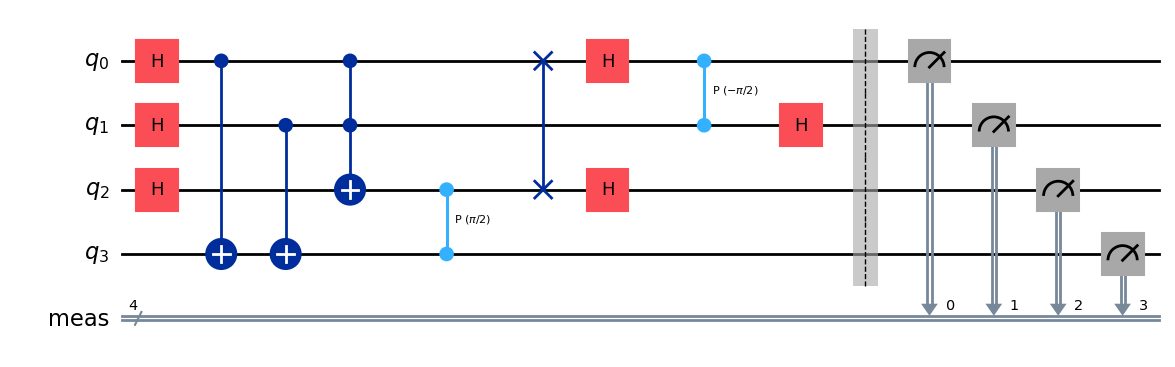

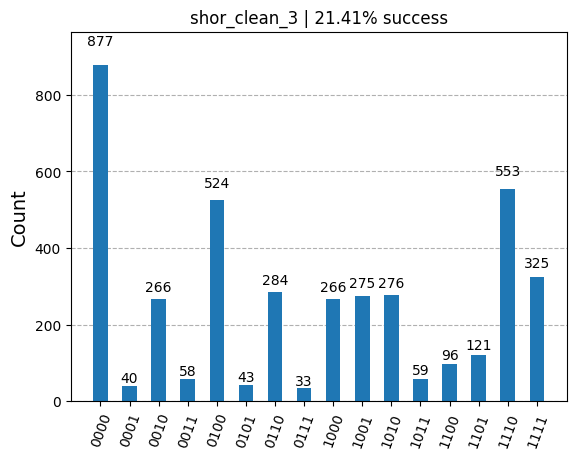

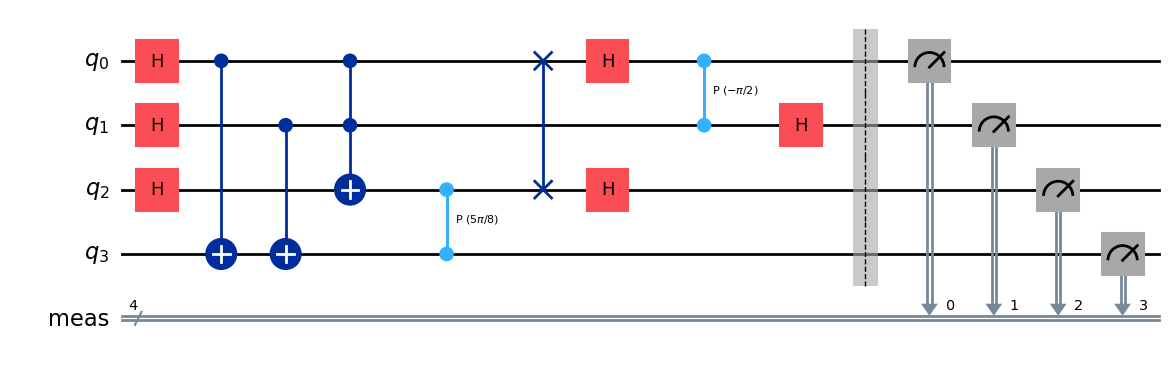

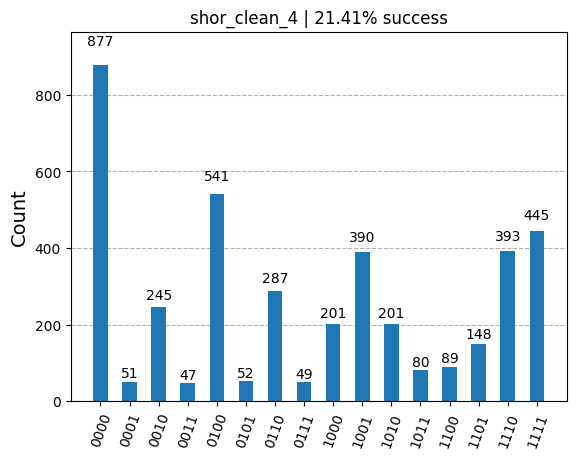

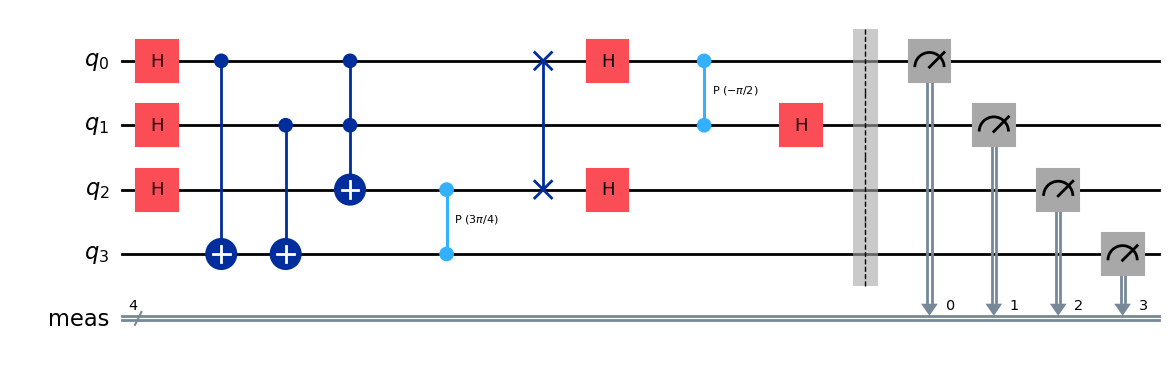

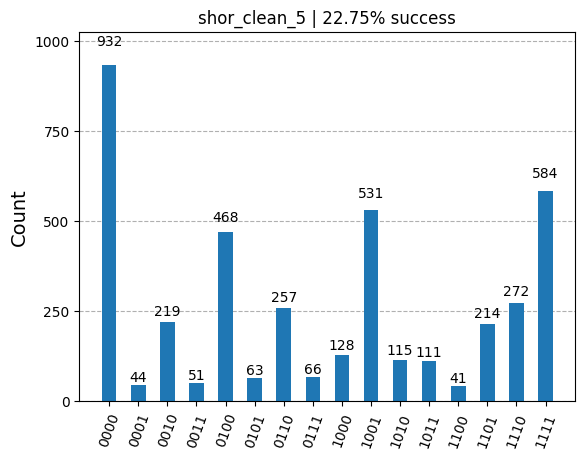

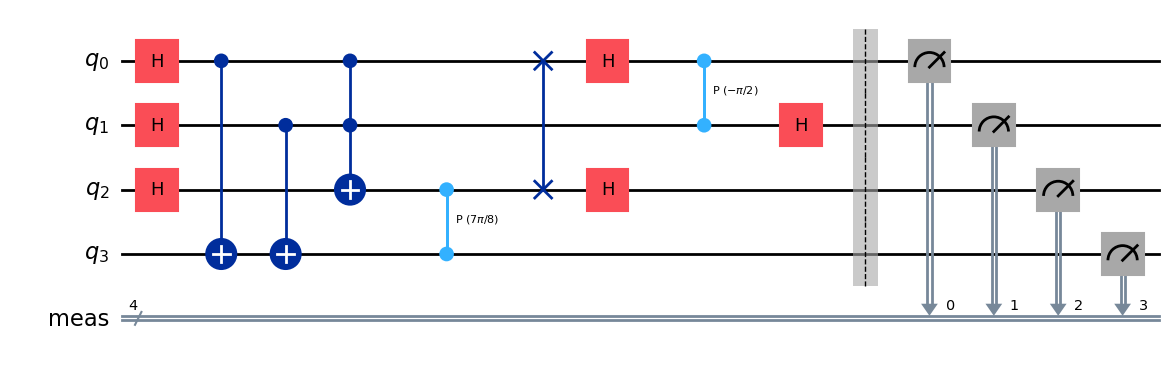

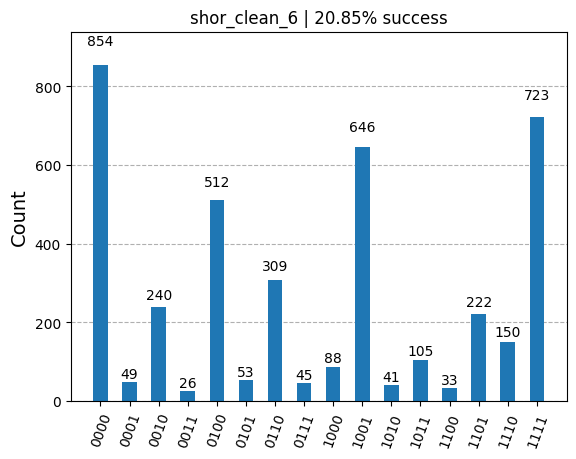

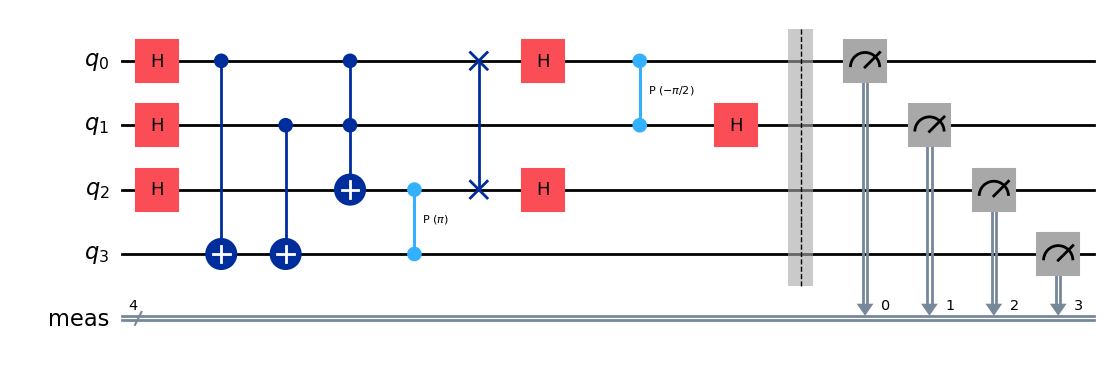

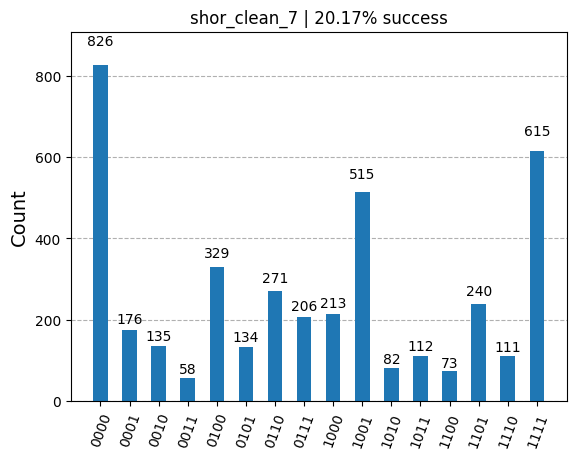

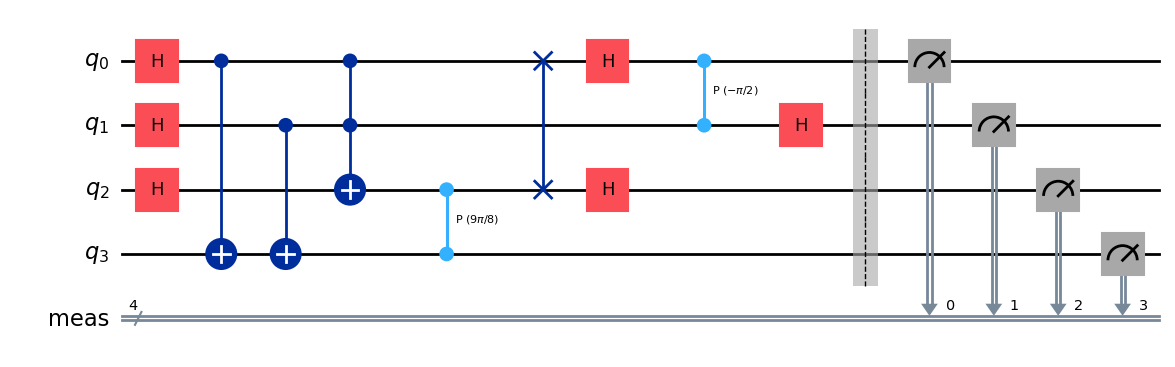

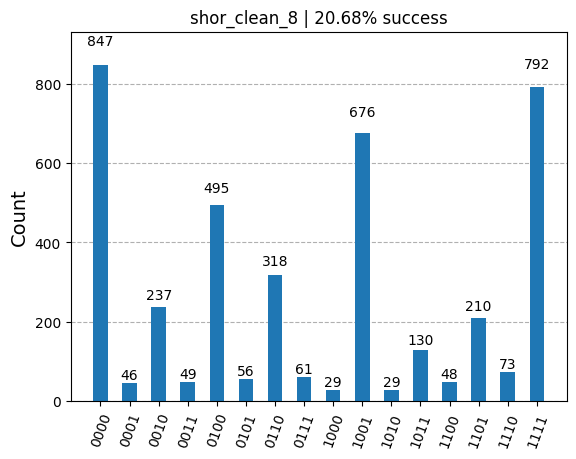

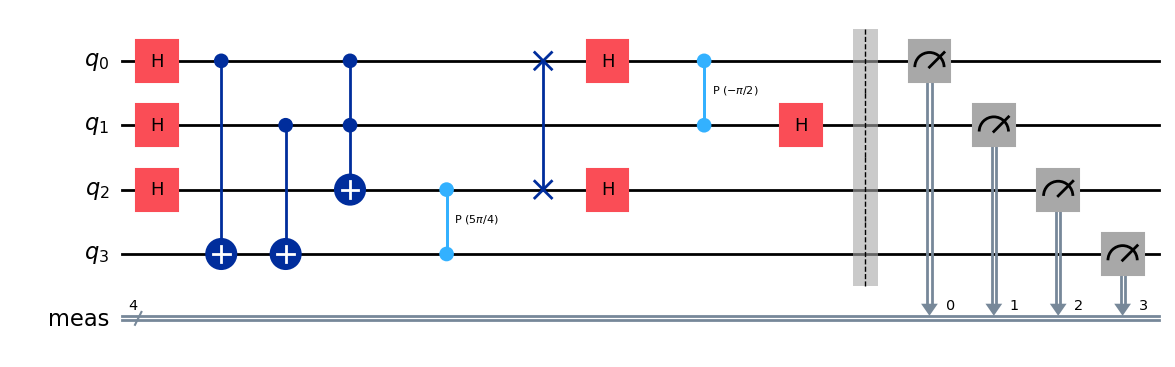

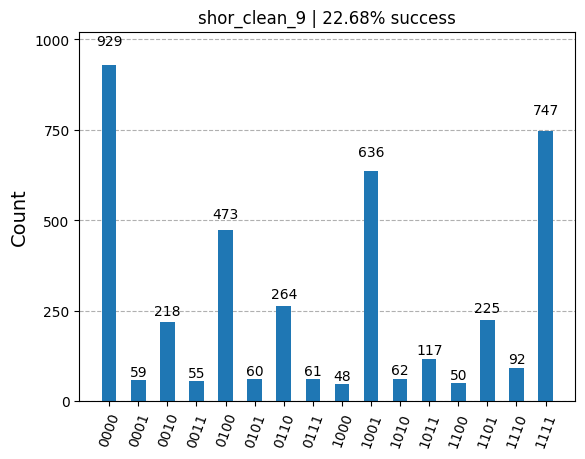

shor_clean_0 | State: 0000 | Success Rate: 21.70%
shor_clean_1 | State: 0000 | Success Rate: 21.39%
shor_clean_2 | State: 0000 | Success Rate: 22.51%
shor_clean_3 | State: 0000 | Success Rate: 21.41%
shor_clean_4 | State: 0000 | Success Rate: 21.41%
shor_clean_5 | State: 0000 | Success Rate: 22.75%
shor_clean_6 | State: 0000 | Success Rate: 20.85%
shor_clean_7 | State: 0000 | Success Rate: 20.17%
shor_clean_8 | State: 0000 | Success Rate: 20.68%
shor_clean_9 | State: 0000 | Success Rate: 22.68%


In [5]:
# --------------------------------------------------
# Simulate, Visualize, and Store Clean Shor Outputs
# --------------------------------------------------

# Create folders for visuals
os.makedirs("shor_clean_diagrams", exist_ok=True)
os.makedirs("shor_clean_histograms", exist_ok=True)

results_summary_shor_clean = []

for i in range(10):
    circuit_name = f"shor_clean_{i}"
    circuit = shor_clean_circuits[circuit_name]

    # Transpile and execute
    transpiled = transpile(circuit, backend=backend)
    sampler = norm_sampler(backend)
    job = sampler.run([transpiled])
    result = job.result()

    # Measurement results
    counts = result[0].data.meas.get_counts()
    success_state = max(counts, key=counts.get)
    percentage = counts[success_state] / sum(counts.values()) * 100

    # Save diagram
    circuit.draw("mpl", filename=f"shor_clean_diagrams/{circuit_name}.png")

    # Save histogram
    fig = plot_histogram(counts, title=f"{circuit_name} | {percentage:.2f}% success")
    fig.savefig(f"shor_clean_histograms/{circuit_name}_histogram.png")
    plt.show()

    # Save results
    results_summary_shor_clean.append({
        "name": circuit_name,
        "success_state": success_state,
        "success_rate": percentage
    })

# Display summary
for res in results_summary_shor_clean:
    print(f"{res['name']} | State: {res['success_state']} | Success Rate: {res['success_rate']:.2f}%")


In [6]:
# --------------------------------------------------
# Feature Extraction for Shor-like Circuits
# --------------------------------------------------

def extract_shor_features(circuit_name, circuit, result, label):
    # Structural features
    ops = circuit.count_ops()
    num_cx = ops.get('cx', 0)
    num_h = ops.get('h', 0)
    num_x = ops.get('x', 0)
    num_ccx = ops.get('ccx', 0)
    num_cp = ops.get('cp', 0)
    num_swap = ops.get('swap', 0)
    depth = circuit.depth()
    total_gates = sum(ops.values())

    # Measurement-based features
    counts = result[0].data.meas.get_counts()
    probs = np.array(list(counts.values()))
    probs = probs / probs.sum()

    success_state = max(counts, key=counts.get)
    success_rate = counts[success_state] / sum(counts.values()) * 100
    entropy = shannon_entropy(probs, base=2)
    unique_states = len(counts)

    return {
        "name": circuit_name,
        "depth": depth,
        "cx": num_cx,
        "h": num_h,
        "x": num_x,
        "cp": num_cp,
        "swap": num_swap,
        "ccx": num_ccx,
        "total_gates": total_gates,
        "success_rate": success_rate,
        "entropy": entropy,
        "unique_states": unique_states,
        "label": label
    }


In [7]:
# --------------------------------------------------
# Feature Extraction & Save: Clean Shor Circuits
# --------------------------------------------------

shor_clean_dataset = []

# Loop through clean Shor circuits
for i in range(10):
    name = f"shor_clean_{i}"
    circuit = shor_clean_circuits[name]

    # Transpile and execute
    transpiled = transpile(circuit, backend=backend)
    sampler = norm_sampler(backend)
    job = sampler.run([transpiled])
    result = job.result()

    # Extract and save features
    features = extract_shor_features(name, circuit, result, label=0)
    shor_clean_dataset.append(features)

# Convert to DataFrame
df_shor_clean = pd.DataFrame(shor_clean_dataset)

# Display and save
print(df_shor_clean)
df_shor_clean.to_csv("shor_clean_dataset.csv", index=False)


           name  depth  cx  h  x  cp  swap  ccx  total_gates  success_rate  \
0  shor_clean_0     10   2  6  0   2     1    1           17     21.826172   
1  shor_clean_1     10   2  6  0   2     1    1           17     22.143555   
2  shor_clean_2     10   2  6  0   2     1    1           17     23.364258   
3  shor_clean_3     10   2  6  0   2     1    1           17     22.607422   
4  shor_clean_4     10   2  6  0   2     1    1           17     21.557617   
5  shor_clean_5     10   2  6  0   2     1    1           17     20.825195   
6  shor_clean_6     10   2  6  0   2     1    1           17     22.143555   
7  shor_clean_7     10   2  6  0   2     1    1           17     19.384766   
8  shor_clean_8     10   2  6  0   2     1    1           17     21.972656   
9  shor_clean_9     10   2  6  0   2     1    1           17     21.826172   

    entropy  unique_states  label  
0  3.193442             16      0  
1  3.286085             16      0  
2  3.392351             16      0

In [8]:
# --------------------------------------------------
# Malicious Shor Circuit Generation (Trojan Simulation)
# --------------------------------------------------

# This section generates 10 adversarially modified Shor-like circuits
# designed to simulate Trojan or malicious logic within the quantum
# subroutine responsible for period-finding in Shor’s algorithm.

# Trojan Simulation Techniques:
# 1. Modular logic corruption: Remove or alter CCX/CX/CU1 sequences
# 2. Angle perturbation: Apply incorrect CP rotations
# 3. Swap tampering: Skip, invert, or misplace critical swaps in inverse QFT
# 4. Output pollution: Inject gates post-QFT (e.g., X or CX gates)
# 5. Decoherence simulation: Redundant or noisy entanglement

# Goals:
# - Make the circuits look visually plausible
# - Subtly degrade performance or change output distributions
# - Enable feature-based classification of circuit integrity

# All malicious samples will be labeled `1` and analyzed alongside
# their clean counterparts in your quantum anomaly detection framework.



In [9]:
# --------------------------------------------------
# Function: Generate Malicious Shor Circuit
# --------------------------------------------------

def generate_shor_malicious_variation(index):
    """
    Generate a tampered version of Shor's period-finding circuit.
    Modifies entanglement, angles, or output routing to simulate Trojan logic.
    """
    n = 3
    qc = QuantumCircuit(n + 1)  # 3 input + 1 ancilla

    # Step 1: Hadamards (same as clean)
    qc.h(range(n))

    # Step 2: Corrupted modular exponentiation
    if index % 3 == 0:
        qc.cx(0, 3)
        qc.x(1)  # Trojan injection
        qc.ccx(0, 1, 2)
    elif index % 3 == 1:
        qc.cx(1, 3)
        qc.cx(2, 3)  # Extra entanglement
        qc.cp(np.pi / 4, 2, 3)
    else:
        qc.ccx(1, 2, 0)
        qc.cp(np.pi / 3, 1, 3)

    # Trojan: Omit or misplace swaps
    if index % 2 == 0:
        qc.swap(1, 2)  # Misrouting
    else:
        pass  # Omit swap to distort inverse QFT

    # Tampered QFT
    qc.h(0)
    qc.cp(-np.pi / 4, 1, 0)
    qc.h(1)
    qc.x(2)  # Post-QFT Trojan

    # Final measurement
    qc.measure_all()

    return qc


In [10]:
# --------------------------------------------------
# Generate & Store All Malicious Shor Circuit Variants
# --------------------------------------------------

# Dictionary to hold malicious Shor circuits
shor_malicious_circuits = {}

# Generate 10 malicious variations
for i in range(10):
    circuit = generate_shor_malicious_variation(i)
    shor_malicious_circuits[f"shor_malicious_{i}"] = circuit


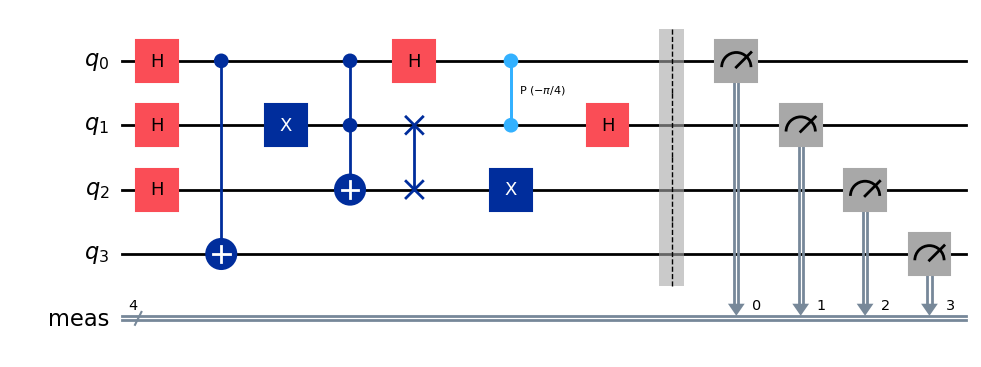

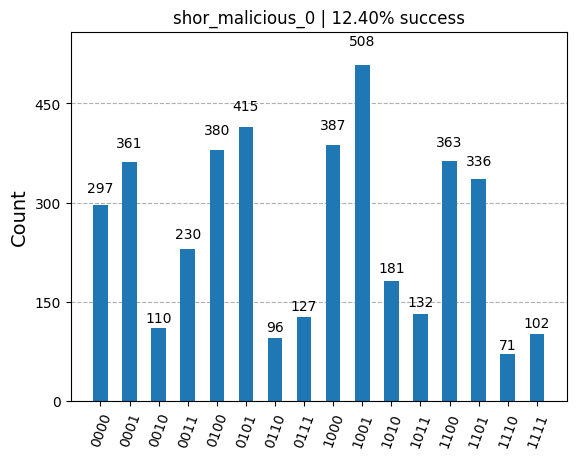

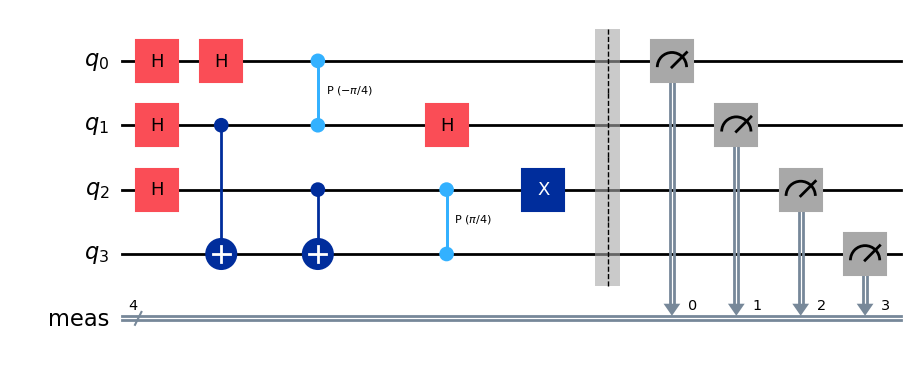

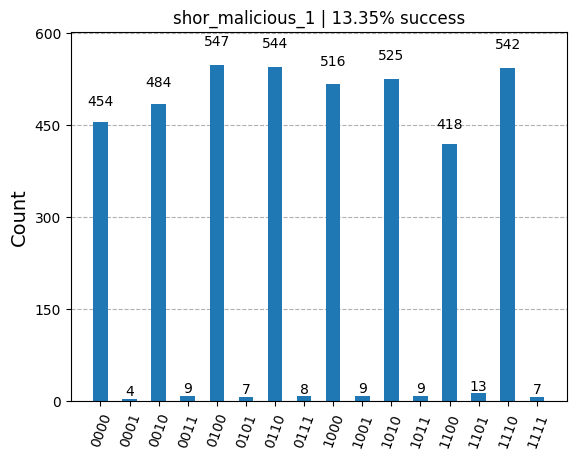

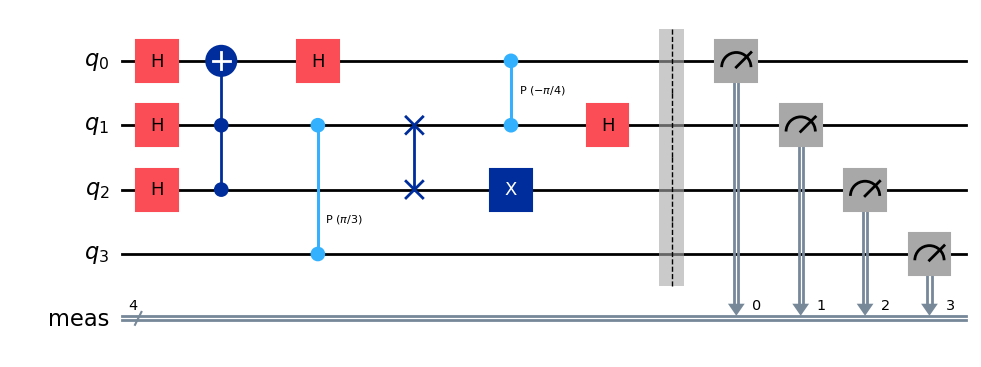

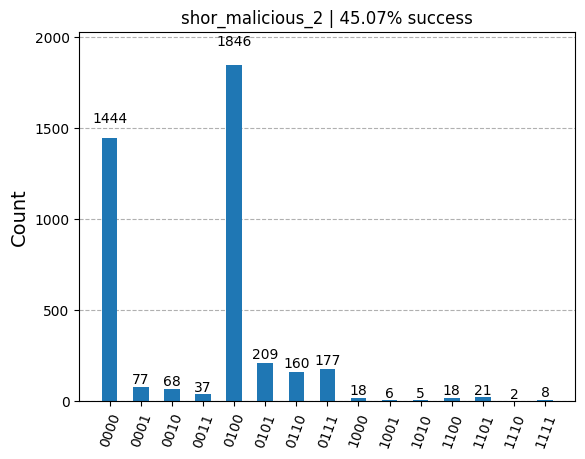

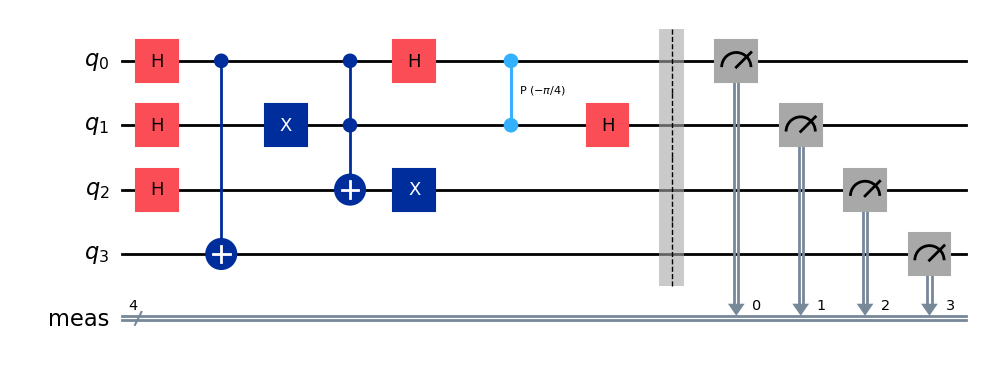

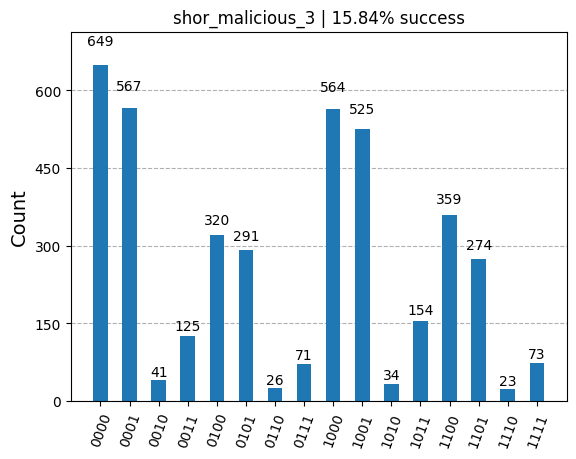

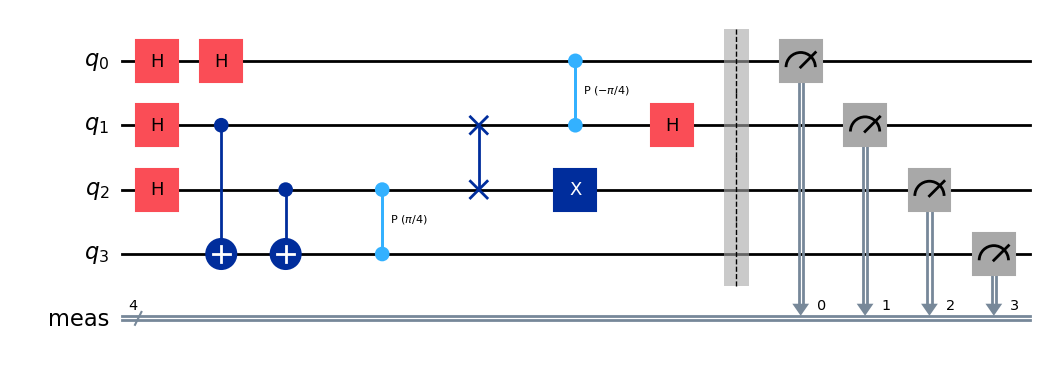

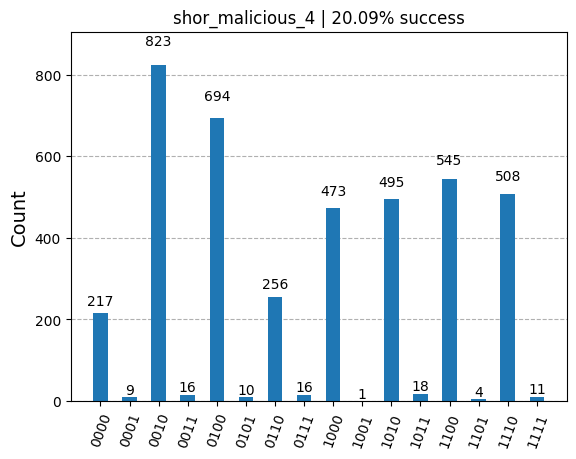

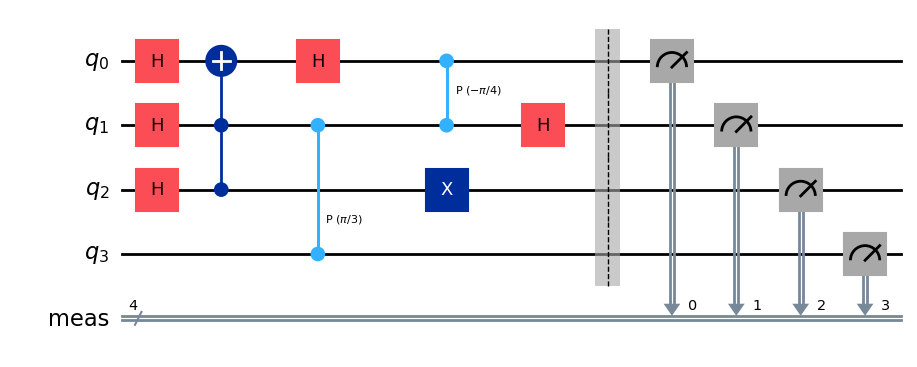

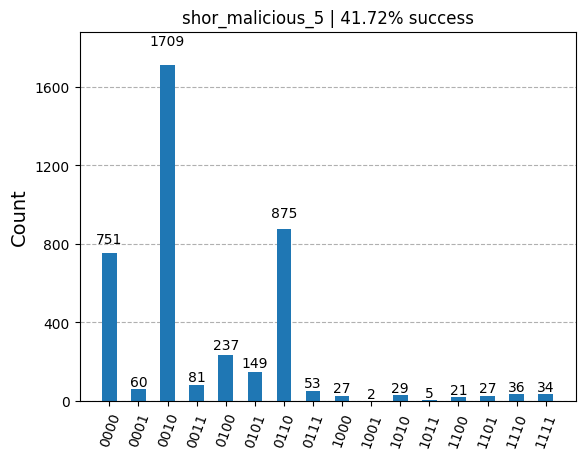

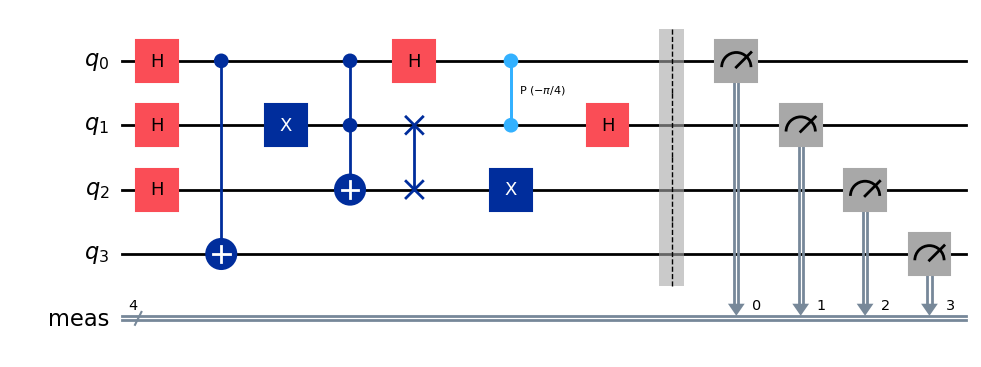

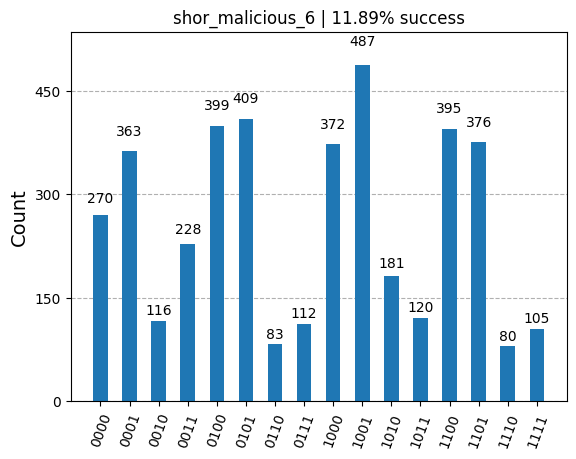

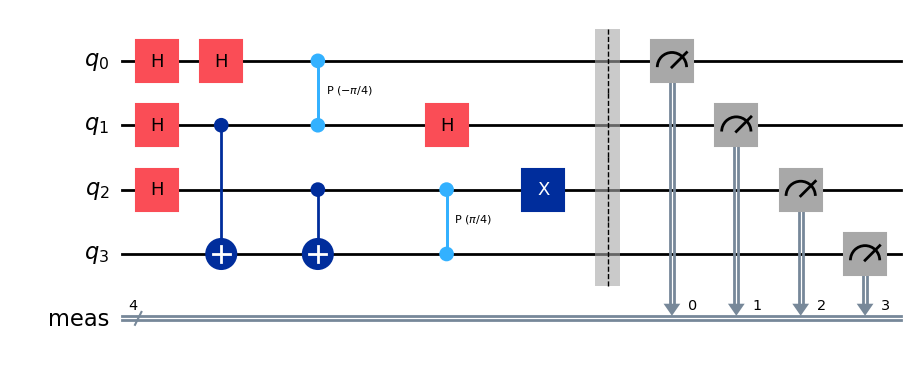

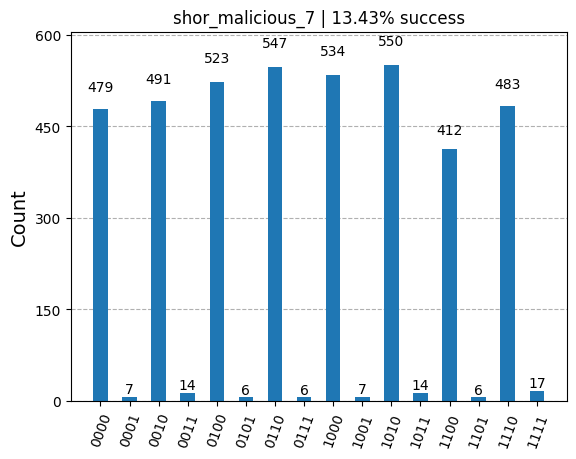

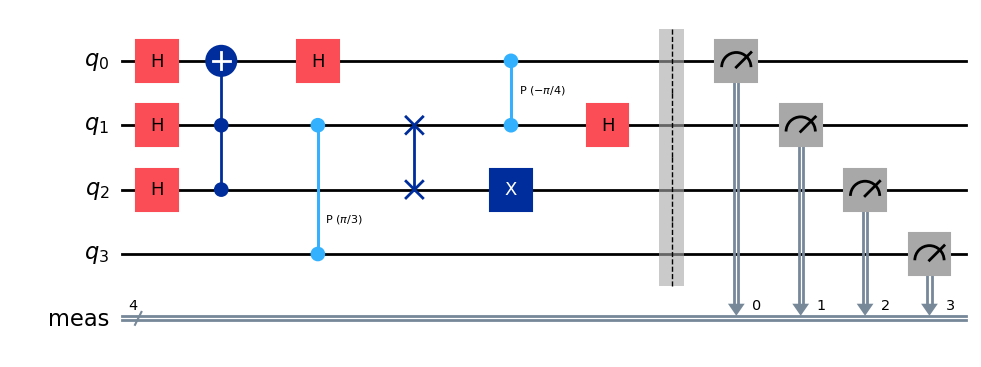

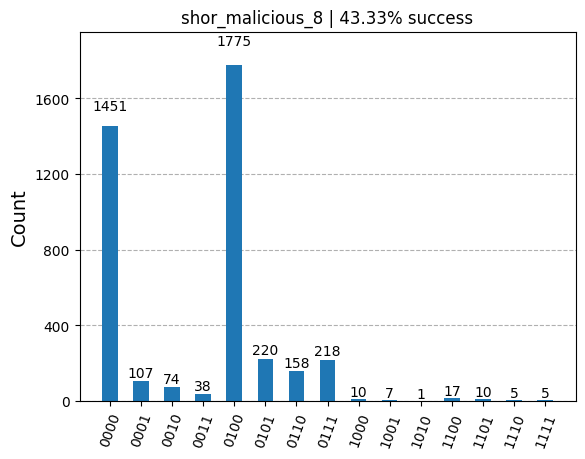

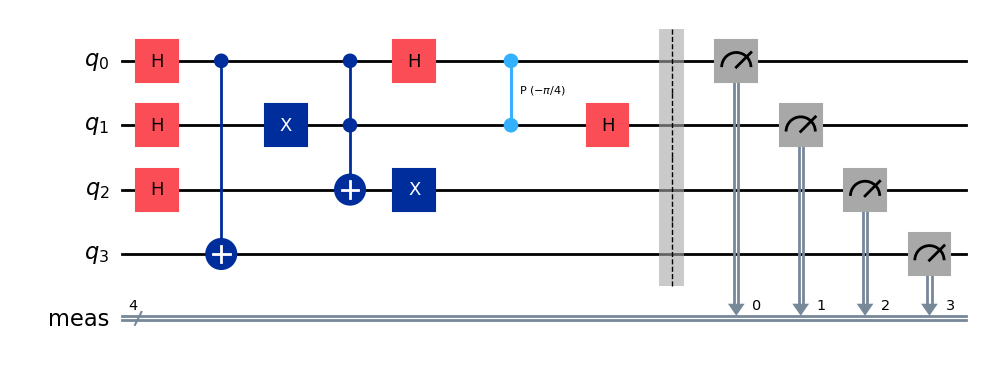

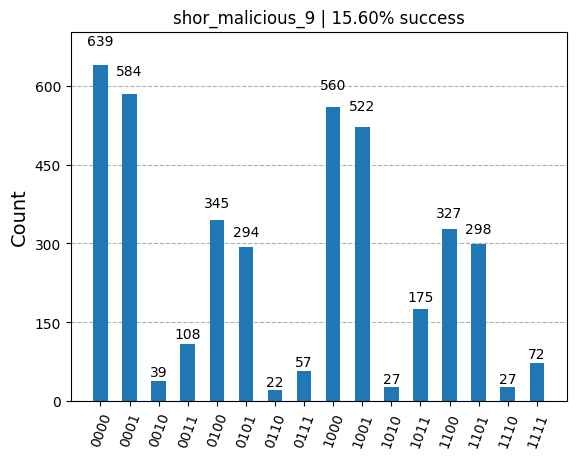

shor_malicious_0 | State: 1001 | Success Rate: 12.40%
shor_malicious_1 | State: 0100 | Success Rate: 13.35%
shor_malicious_2 | State: 0100 | Success Rate: 45.07%
shor_malicious_3 | State: 0000 | Success Rate: 15.84%
shor_malicious_4 | State: 0010 | Success Rate: 20.09%
shor_malicious_5 | State: 0010 | Success Rate: 41.72%
shor_malicious_6 | State: 1001 | Success Rate: 11.89%
shor_malicious_7 | State: 1010 | Success Rate: 13.43%
shor_malicious_8 | State: 0100 | Success Rate: 43.33%
shor_malicious_9 | State: 0000 | Success Rate: 15.60%


In [11]:
# --------------------------------------------------
# Run & Save Malicious Shor Circuits on IBM Backend
# --------------------------------------------------

# Create folders for visuals
os.makedirs("shor_malicious_diagrams", exist_ok=True)
os.makedirs("shor_malicious_histograms", exist_ok=True)

results_summary_shor_malicious = []

for i in range(10):
    circuit_name = f"shor_malicious_{i}"
    circuit = shor_malicious_circuits[circuit_name]

    # Transpile and execute
    transpiled = transpile(circuit, backend=backend)
    sampler = norm_sampler(backend)
    job = sampler.run([transpiled])
    result = job.result()

    # Measurement results
    counts = result[0].data.meas.get_counts()
    success_state = max(counts, key=counts.get)
    percentage = counts[success_state] / sum(counts.values()) * 100

    # Save diagram
    circuit.draw("mpl", filename=f"shor_malicious_diagrams/{circuit_name}.png")

    # Save histogram
    fig = plot_histogram(counts, title=f"{circuit_name} | {percentage:.2f}% success")
    fig.savefig(f"shor_malicious_histograms/{circuit_name}_histogram.png")
    plt.show()

    # Store results
    results_summary_shor_malicious.append({
        "name": circuit_name,
        "success_state": success_state,
        "success_rate": percentage
    })

# Display summary
for res in results_summary_shor_malicious:
    print(f"{res['name']} | State: {res['success_state']} | Success Rate: {res['success_rate']:.2f}%")


In [12]:
# --------------------------------------------------
# Feature Extraction & Save: Malicious Shor Circuits
# --------------------------------------------------

shor_malicious_dataset = []

# Loop through all malicious Shor circuits
for i in range(10):
    name = f"shor_malicious_{i}"
    circuit = shor_malicious_circuits[name]

    # Transpile and execute
    transpiled = transpile(circuit, backend=backend)
    sampler = norm_sampler(backend)
    job = sampler.run([transpiled])
    result = job.result()

    # Extract features
    features = extract_shor_features(name, circuit, result, label=1)
    shor_malicious_dataset.append(features)

# Convert to DataFrame
df_shor_malicious = pd.DataFrame(shor_malicious_dataset)

# Display and save
print(df_shor_malicious)
df_shor_malicious.to_csv("shor_malicious_dataset.csv", index=False)


               name  depth  cx  h  x  cp  swap  ccx  total_gates  \
0  shor_malicious_0      7   1  5  2   1     1    1           16   
1  shor_malicious_1      6   2  5  1   2     0    0           15   
2  shor_malicious_2      7   0  5  1   2     1    1           15   
3  shor_malicious_3      7   1  5  2   1     0    1           15   
4  shor_malicious_4      8   2  5  1   2     1    0           16   
5  shor_malicious_5      6   0  5  1   2     0    1           14   
6  shor_malicious_6      7   1  5  2   1     1    1           16   
7  shor_malicious_7      6   2  5  1   2     0    0           15   
8  shor_malicious_8      7   0  5  1   2     1    1           15   
9  shor_malicious_9      7   1  5  2   1     0    1           15   

   success_rate   entropy  unique_states  label  
0     11.987305  3.774289             16      1  
1     13.647461  3.117252             16      1  
2     42.968750  2.101470             15      1  
3     15.966797  3.425054             16      1  
4

In [14]:
# --------------------------------------------------
# Merge Clean + Malicious Shor Datasets
# --------------------------------------------------

# Combine both datasets
df_shor_combined = pd.concat([df_shor_clean, df_shor_malicious], ignore_index=True)

# Save merged dataset
df_shor_combined.to_csv("shor_full_dataset.csv", index=False)

# Display preview
print("Combined Shor Dataset (Clean + Malicious):")
print(df_shor_combined.head(4))


Combined Shor Dataset (Clean + Malicious):
           name  depth  cx  h  x  cp  swap  ccx  total_gates  success_rate  \
0  shor_clean_0     10   2  6  0   2     1    1           17     21.826172   
1  shor_clean_1     10   2  6  0   2     1    1           17     22.143555   
2  shor_clean_2     10   2  6  0   2     1    1           17     23.364258   
3  shor_clean_3     10   2  6  0   2     1    1           17     22.607422   

    entropy  unique_states  label  
0  3.193442             16      0  
1  3.286085             16      0  
2  3.392351             16      0  
3  3.468424             16      0  


C:\Users\zeesh\AppData\Local\Temp\ipykernel_38416\1495925784.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='Count', data=label_df, palette='Set2')


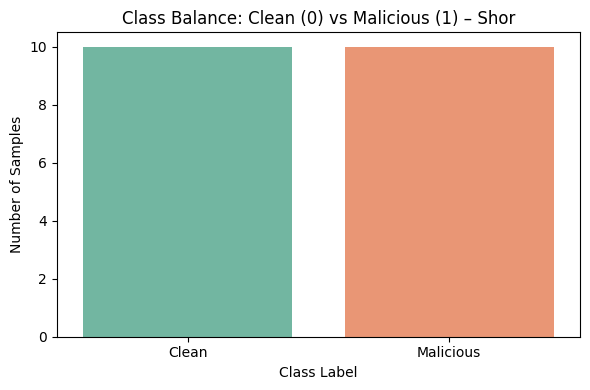

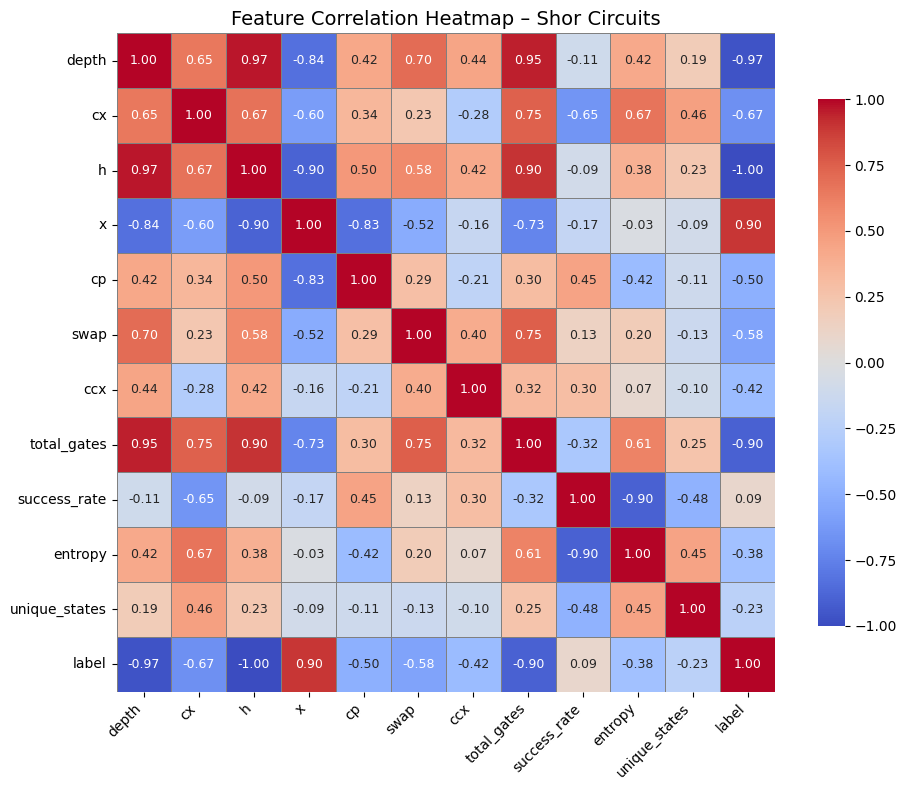

In [15]:
# --------------------------------------------------
# Dataset Analysis: Class Balance & Feature Correlation – Shor
# --------------------------------------------------

# Create folder for plots
os.makedirs("shor_analysis_plots", exist_ok=True)

# ---------- CLASS BALANCE ----------
label_counts = df_shor_combined['label'].value_counts().sort_index()
label_df = pd.DataFrame({
    'Label': ['Clean', 'Malicious'],
    'Count': label_counts.values
})

# Plot class distribution
plt.figure(figsize=(6, 4))
sns.barplot(x='Label', y='Count', data=label_df, palette='Set2')
plt.title("Class Balance: Clean (0) vs Malicious (1) – Shor")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.savefig("shor_analysis_plots/shor_class_balance.png")
plt.show()

# ---------- FEATURE CORRELATION HEATMAP ----------
numeric_df = df_shor_combined.drop(columns=["name"])
numeric_df = numeric_df.loc[:, numeric_df.std() > 0]  # Remove constant columns

correlation = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    linecolor='gray',
    square=True,
    cbar_kws={'shrink': 0.8},
    annot_kws={"size": 9}
)

plt.title("Feature Correlation Heatmap – Shor Circuits", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("shor_analysis_plots/shor_feature_correlation_heatmap.png", dpi=300)
plt.show()
